In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np 
import optax as ox
import xarray as xr

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

2022-06-01 16:38:00.011029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Data Read

### Obs

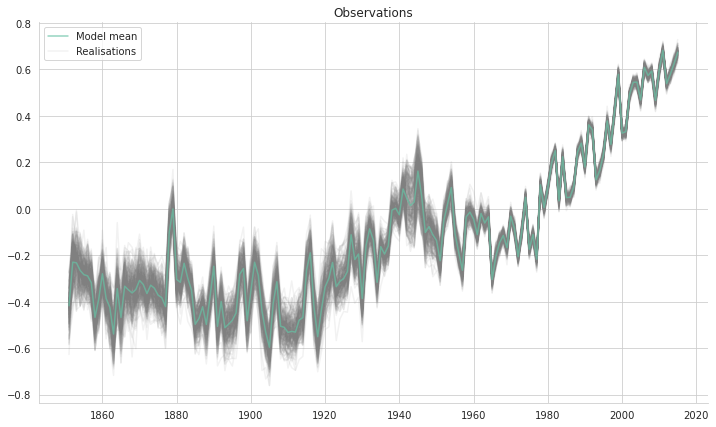

In [2]:
obs_da = xr.open_dataarray("data/obs/GMST_OBS.nc")
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
observations.plot()
sns.despine()

### Anomaly model data

<AxesSubplot:>

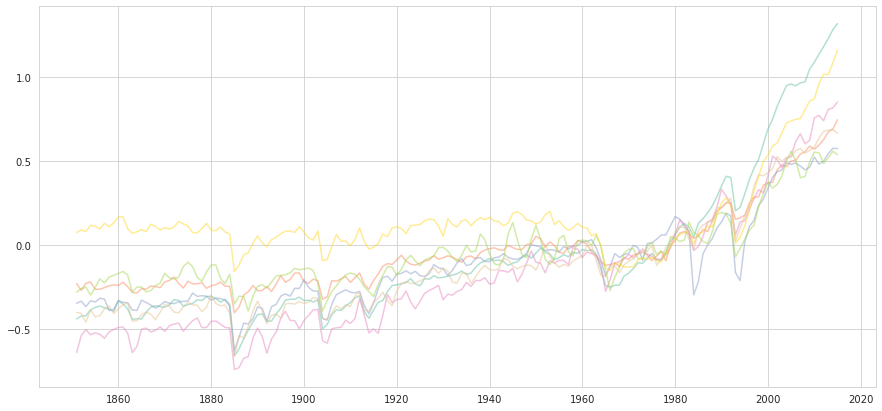

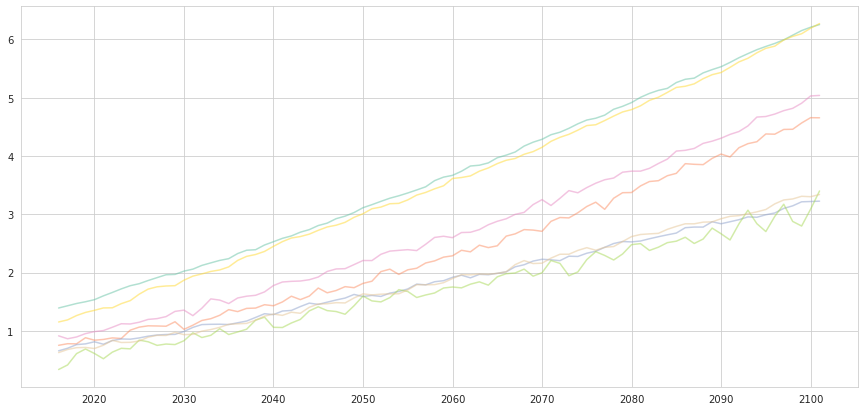

In [4]:
hist_model_files = dict()
for model_file in sorted(glob('data/gmst/historical/*nc')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    hist_model_files[model_name] = model_file

ssp_model_files = dict()
for model_file in sorted(glob('data/gmst/ssp370/*nc')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    ssp_model_files[model_name] = model_file

model_overlap = np.intersect1d(list(hist_model_files.keys()), list(ssp_model_files.keys())).tolist()
hist_model_files = {k:hist_model_files[k] for k in hist_model_files if k in model_overlap}
ssp_model_files = {k:ssp_model_files[k] for k in ssp_model_files if k in model_overlap}

hist_anom_models = []
climatology_dict = dict()

for mn, mf in hist_model_files.items():
    # Read in model data into a ProcessModel datatype
    da = xr.open_dataarray(mf)
    da['time'] = obs_time
    model_data = es.ProcessModel(da, mn)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
    hist_anom_models.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

hist_anom_models = es.ModelCollection(hist_anom_models)
hist_anom_models.plot_all()

ssp_anom_models = []
for mn, mf in ssp_model_files.items():
    # Read in model data into a ProcessModel datatype
    da = xr.open_dataarray(mf)
    model_data = es.ProcessModel(da, mn)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(climatology=climatology_dict[mn], resample_freq='Y')
    ssp_anom_models.append(anomaly_model)

ssp_anom_models = es.ModelCollection(ssp_anom_models)
ssp_anom_models.plot_all()

### Construct posteriors for historic data

In [5]:
# hist_anom_models.fit(model=es.MeanFieldApproximation(), compile_objective=True, n_optim_nits=2500)

In [6]:
hist_anom_models.fit(model=es.GPDTW1D(), compile_objective=True)

2022-06-01 16:38:28.490670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-01 16:38:28.490696: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-01 16:38:28.526244: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
100%|██████████| 500/500 [00:24<00:00, 20.18it/s, loss=-123.72]
/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "
100%|██████████| 500/500 [00:23<00:00, 21.26it/s, loss=-180.02]


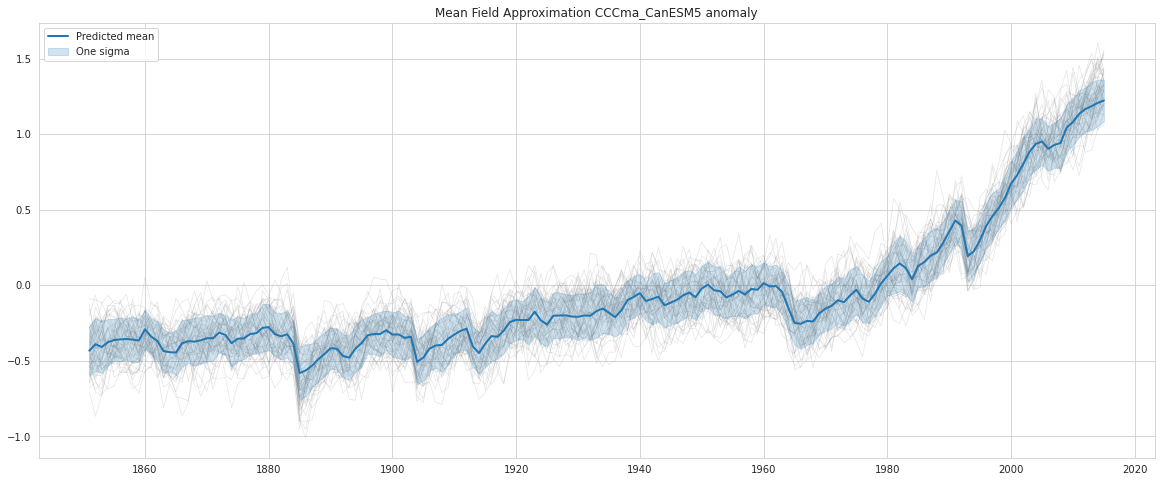

In [7]:
model_idx = 0
mu = hist_anom_models[model_idx].distribution.mean
stddev = np.sqrt(hist_anom_models[model_idx].distribution.variance)
realisations = hist_anom_models[model_idx].model_data.values

fig,ax = plt.subplots(figsize=(20,8))
ax.plot(hist_anom_models[model_idx].time, mu, color='tab:blue', label='Predicted mean', linewidth=2, zorder=2)
ax.fill_between(hist_anom_models[model_idx].time.values, mu - stddev, mu + stddev, color='tab:blue', alpha=0.2, label='One sigma', zorder=2)
ax.plot(hist_anom_models[model_idx].time, realisations.T, color='tab:gray', alpha=0.2, zorder=1, linewidth=0.7)
ax.legend(loc='best')
ax.set_title(f'Mean Field Approximation {hist_anom_models[model_idx].model_name}')
plt.show()

In [8]:
weight_function = es.LogLikelihoodWeight()
weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:00<00:00, 273.83it/s]


In [9]:
ensemble_method = es.Barycentre()
output_ensemble = ensemble_method(hist_anom_models, weights)

  0%|          | 0/165 [00:00<?, ?it/s]2022-06-01 16:47:22.755598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 16:47:22.765805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
100%|██████████| 165/165 [00:05<00:00, 28.67it/s] 


### Hindcast ensemble

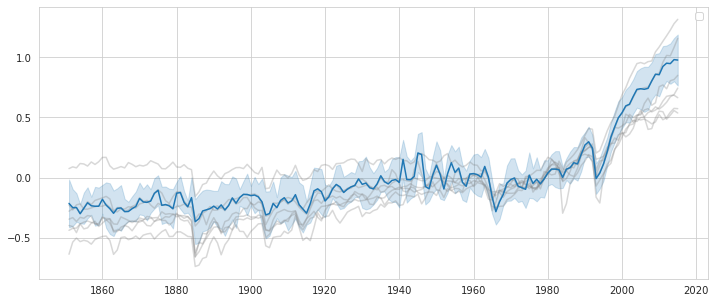

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))
hist_anom_models.plot_all(one_color='tab:gray', ax=ax)
output_ensemble.plot(ax)
ax.legend(loc='best')

### Forecast Ensemble

In [11]:
ssp_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=1000)

/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "
100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s, loss=-67.86]


In [13]:
single_ll_weights = weights.mean('time').expand_dims(time=ssp_anom_models[0].model_data.time, axis=1)

In [14]:
ensemble_method = es.Barycentre()
output_ensemble = ensemble_method(ssp_anom_models, single_ll_weights)

  0%|          | 0/86 [00:00<?, ?it/s]2022-06-01 17:00:03.651738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 17:00:03.663930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
100%|██████████| 86/86 [00:05<00:00, 16.76it/s]


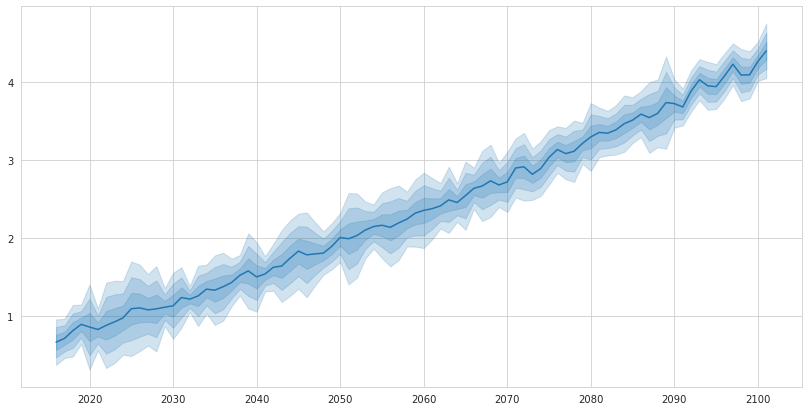

In [17]:
output_ensemble.plot_temporally()

### Calculate weights using different schemes

In [5]:
uniform_weights = es.UniformWeight()(hist_anom_models)
mse_weights = es.InverseSquareWeight()(hist_anom_models, observations)

weight_function = es.LogLikelihoodWeight()
ll_weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:07<00:00, 27.51it/s]


### Construct different ensemble outputs

In [6]:
weighted_mean = es.WeightedModelMean()(hist_anom_models, weights=mse_weights)
multi_model_mean = es.MultiModelMean()(hist_anom_models)
weighted_barycentre = es.Barycentre()(hist_anom_models, weights=ll_weights)

100%|██████████| 1980/1980 [00:18<00:00, 107.27it/s]
